- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2024  
- **conda environment**: I used the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

# fMRI Data Analysis: Group-Level Analysis

Once you have beta (or contrast) maps for conditions (or contrasts) from all subjects, you can perform group-level statistics. Importantly, all subject first-level results need to be in common space, e.g., MNI, to perform voxel-wise group analyses. Group-level analysis allows you to make inferences about the population, rather than individual subjects, by assessing common patterns across participants. Common statistical methods for group-level analysis include one-sample or paired t-tests, as well as more complex ANOVA models, depending on your study design.

In this tutorial, we illustrate a simple one-sample t-test on the contrast of Faces-Scrambled that we calculated for each subject in the previous notebook. Then we will try an ANOVA in which we include 9 contrasts, one for each of the 9 experimental conditions (averaged across runs), as well as 16 additional regressors to remove between-subject variance. This corresponds to a repeated-measures ANOVA, though assumes that the (pooled) error is spherical *(see [Rik’s Stats tutorial](../02_Statistics/cognestic_stats_python.ipynb) on ANOVA for the importance of this)*. 
To mitigate this issue, we can use Nilearn's non-parametric inference, which we will employ for our final results in this group-level analysis example.

Here is a recommended viewing to help better understand the principles of the group-level analysis:

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('__cOYPifDWk', width=560, height=315)


---------------

**Table of contents**    
1. Import required packages and set up some stuff    
2. Retrieve First-Level results    
3. Displaying subject Effects-Of-Interest z-maps    
4. Specify the second-level model    
4.1. Design matrix    
4.2. Contrasts  
4.3. Model specification and fit   
5. Computing contrasts and plotting result maps    
5.1. False-positive-rate with cluster-forming threshold   
5.2. FWE correction using Bonferroni correction   
5.3. FWE correction using non-parametric permutation testing    
6. Summary results  
6.1. Using atlasreader package    
6.2. Nilearn's report   

-----
## Import required packages and set up some stuff

In [1]:
# The conda environment used for this tutorial is available here: https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml 

import os
import os.path as op # for file path operations
import glob # to search for files using regex

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

import matplotlib.pyplot as plt # for basic plotting

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.plotting import plot_glass_brain, plot_design_matrix, plot_contrast_matrix, plot_stat_map, view_img, view_img_on_surf
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import non_parametric_inference

from atlasreader import create_output # For generating result tables https://github.com/miykael/atlasreader

wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/' # <-- CHANGE TO YOURS
os.chdir(wd)
print(f"Working directory currently {os.getcwd()}")

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data

Working directory currently /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing


In [2]:
# MNI152 template will be used as a backgound for plotting results
mni152_template = load_mni152_template()

## Retrieve First-Level results

For the group analysis, we will use the single-condition contrast estimate (beta estimate) maps for all nine conditions. Because we saved the results in BIDS format, we can us PyBIDS to retrieve the subject-level results. 

In [3]:
# --- Set up the paths to the data and results folders
fmri_data_dir = 'data' # data in BIDS format
fmri_results_dir = 'results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must comply with BIDS standards, and include dataset_description.json file!
layout.add_derivatives(op.join(fmri_results_dir, "first-level"))
subjects = layout.get_subjects()

Specify which conditions to include in the analysis and retrieve their effect files from the first-level results.

## Displaying Z-maps for each subject

To check how the first-level results look overall, it is helpful to display the Faces-Scrambled contrast for all subjects. Let's find these and then plot.

In [4]:
fac_scr_maps = layout.get(desc='Faces', suffix="effect", extension='.nii.gz', return_type='file')
#fac_scr_maps = layout.get(desc='FacesScrambled', suffix="effect", extension='.nii.gz', return_type='file')
print(*fac_scr_maps, sep="\n")

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/first-level/sub-01/sub-01_ses-mri_task-facerecognition_desc-Faces-Scrambled_effect.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/first-level/sub-02/sub-02_ses-mri_task-facerecognition_desc-Faces-Scrambled_effect.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/first-level/sub-03/sub-03_ses-mri_task-facerecognition_desc-Faces-Scrambled_effect.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/first-level/sub-04/sub-04_ses-mri_task-facerecognition_desc-Faces-Scrambled_effect.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/first-level/sub-05/sub-05_ses-mri_task-facerecognition_desc-Faces-Scrambled_effect.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/first-level/sub-06/sub-06_ses-mri_task-facerecognition_desc-Faces-Scrambled_effect.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/result

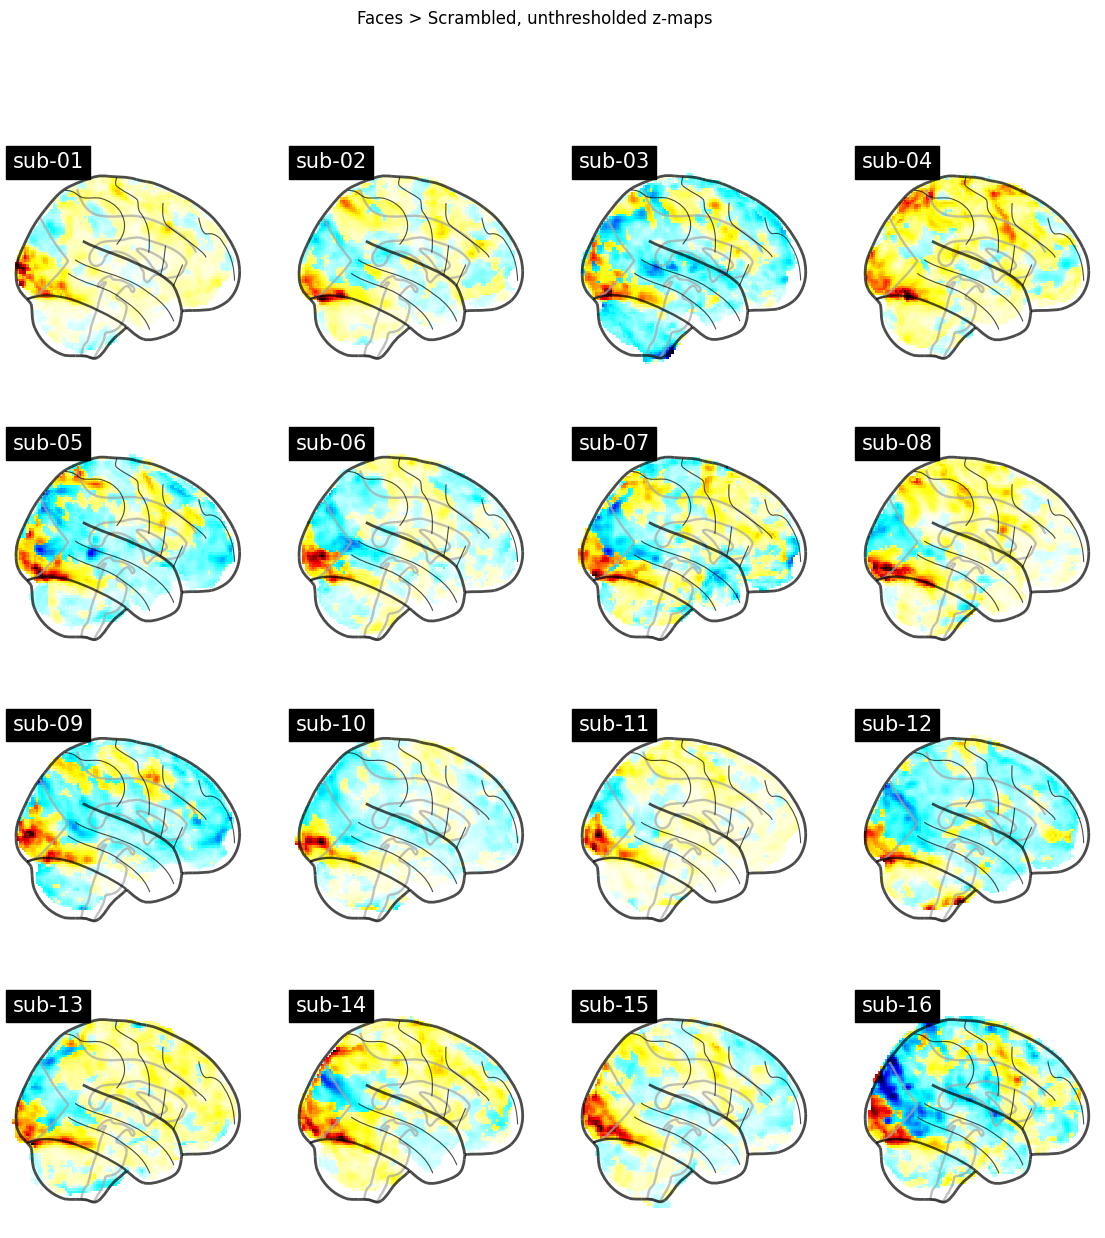

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i, stat_map in enumerate(fac_scr_maps):
    plot_glass_brain(stat_map, 
                              title = 'sub-' + subjects[i],
                              axes = axes[int(i / 4), int(i % 4)],
                              plot_abs = False, 
                              display_mode='x')
fig.suptitle('Faces > Scrambled' + ', unthresholded z-maps');

## Specify second-level models

At the group-level analysis, we also use a GLM. The outcome variable is the beta/contrast estimate from each subject, and the predictor variables typically include group-level factors such as experimental conditions, subject-specific regressors (in repeated-measures designs), group-specific regressors (in between-subject designs), and subject-specific covariates (e.g., age, gender, or behavioural scores). First we start with the simplest of all GLMs: the one-sample T-test...

### One-sample T-test for Faces > Scrambled

One approach is to define all one's contrasts in the first-level (individual subject) models, and take these to the second-level. When those contrasts are all T-tests, the second level model corresponds to a one-sample T-test, i.e, testing whether those contrasts are significantly above or below zero when averaged across participants. This is called the "partitioned error" or "summary statistic" approach (such that the error in the one-sample t-test corresponds to the contrast x subject interaction in a repeated-measures ANOVA). With this approach, one has to estimate a new second-level model for each contrast of interest. See [Rik's Stats notebook](../02_Statistics/cognestic_stats_python.ipynb) for more information (e.g, how to handle F-contrasts in such cases).

Later we will try the alternative approach, which is to take the parameter estimates (averaged across runs) for all of the individual conditions into a larger ANOVA model at the second-level (in our case, all 9 conditions, corresponding to a 3x3 ANOVA). This is called the "pooled error" approach. This can be more powerful, and simpler, because all one's contrasts can be tested within a single model. However, it makes stronger assumptions about the sphericity of the error, which may be violated, which is why the above "partitioned error" approach is generally safer. Again, see [Rik's Stats notebook](../02_Statistics/cognestic_stats_python.ipynb) for more information.

In [6]:
design_matrix = pd.DataFrame([1]*len(subjects), index=subjects, columns=["fac-scr"])
second_level_model = SecondLevelModel() 
second_level_model = second_level_model.fit(
  fac_scr_maps, 
  design_matrix = design_matrix
  )

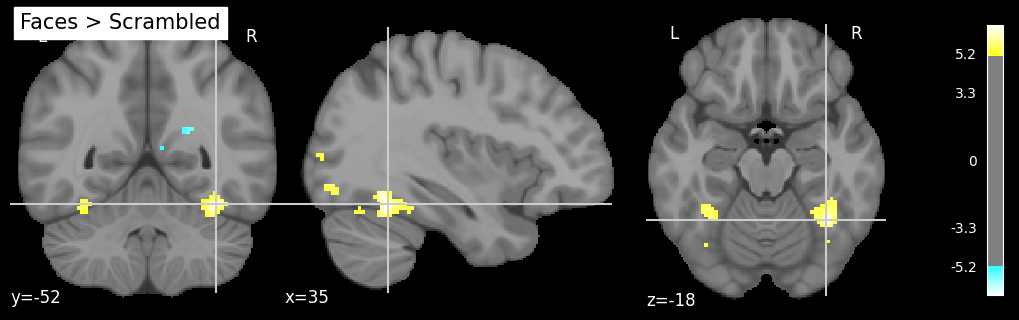

In [7]:
contrasts = {'FacesScrambled': [1]}
z_map = second_level_model.compute_contrast(contrasts['FacesScrambled'], output_type="z_score")
thresholded_map_fpr, threshold_fpr = threshold_stats_img(
    z_map, 
    alpha=0.05, 
    height_control='bonferroni', 
    two_sided=True)

# save so we can use to define a mask later
nib.save(thresholded_map_fpr, op.join(fmri_results_dir,'faces-scrambled_Zmap_fdr.nii.gz'))

plot_stat_map(
    thresholded_map_fpr,
    bg_img = mni152_template, 
    threshold = threshold_fpr,   
    display_mode = 'ortho',
    black_bg = True,    
    title = 'Faces > Scrambled')
fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

### 3x3 Repeated-measures ANOVA

In this example, the design matrix we generate will represent a mixed-effects design, incorporating both **within-subject (conditions)** and **between-subject (subjects)** factors. Each row in the design matrix corresponds to a specific observation, which in this case is a beta estimate from a given condition and subject, while each column represents a predictor variable.

The number of rows in the design matrix must match the number of first-level result files that will be entered into the second-level model. The order of the rows in the design matrix must match the order of the provided files.

In [9]:
conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']

effect_files = layout.get(desc=conditions, suffix='effect', extension='.nii.gz', return_type='filename')

# print to see if it found what we expexted
print(f"Found {len(effect_files)} effect files")
#print(*effect_files, sep="\n")

Found 144 effect files


Note we have reordered conditions so that the "stimulus" factor (famous face, unfamiliar face, scrambled face) rotates slowest, and "presentation" factor (initial, immediate repeat, delayed repeat) rotates fastest in this 3x3 design.

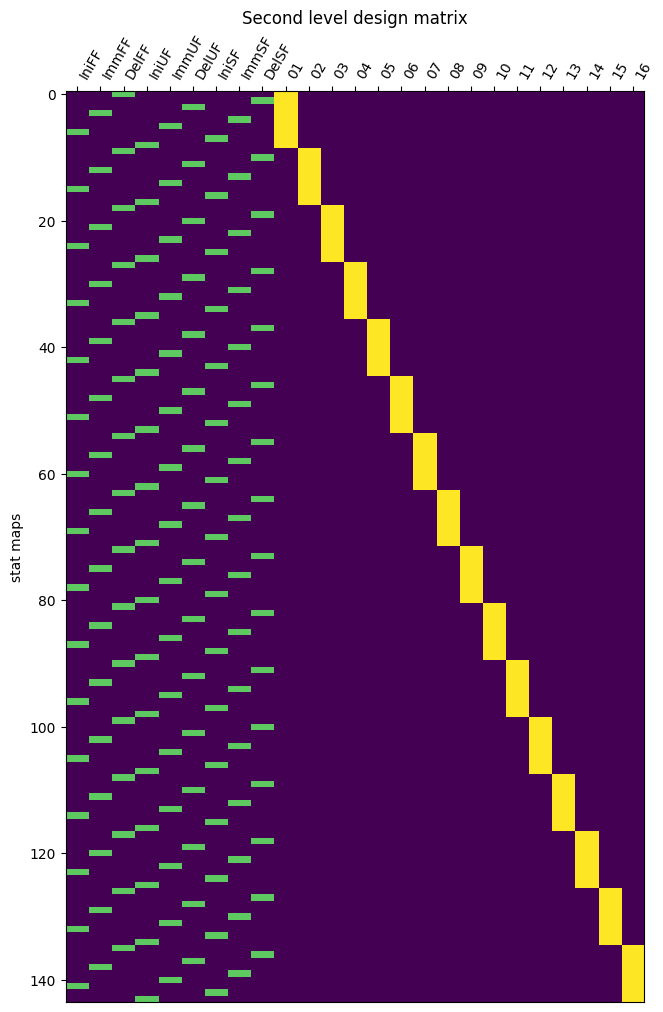

In [10]:
design_matrix = pd.DataFrame(columns=conditions + subjects)

# Populate the DataFrame with 0s and 1s for conditions
for i, condition in enumerate(conditions):
    # Filter files based on condition
    condition_files = [1 if condition in file else 0 for file in effect_files]
    # Add a column for the condition
    design_matrix[condition] = condition_files

# Populate the DataFrame with 0s and 1s for subjects
for i, subject in enumerate(subjects):
    # Filter files based on subject
    subject_files = [1 if f"sub-{subject}" in file else 0 for file in effect_files]
    # Add a column for the subject
    design_matrix[subject] = subject_files
    
ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12);
ax.set_ylabel("stat maps");

The first 9 columns capture the mean of each condition, while the remaining 16 columns capture the mean of each subject (which we do not care about, and removing this variance can improve statistics for contrasts over the first 9 columns by reducing the residual error).

In [11]:
second_level_model = SecondLevelModel() 
second_level_model = second_level_model.fit(
  effect_files, 
  design_matrix = design_matrix
  )

#### Some contrasts

We can specify some contrasts that might be of interest. The first two are T-contrasts (one row), the last is an F-contrast (more than one row):

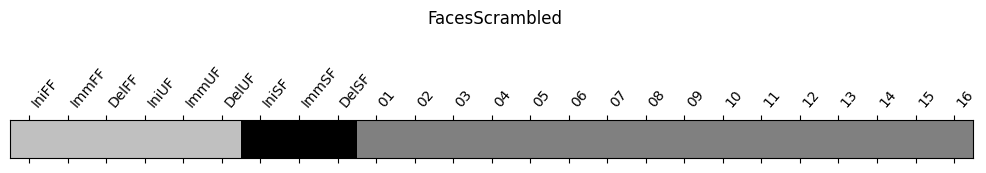

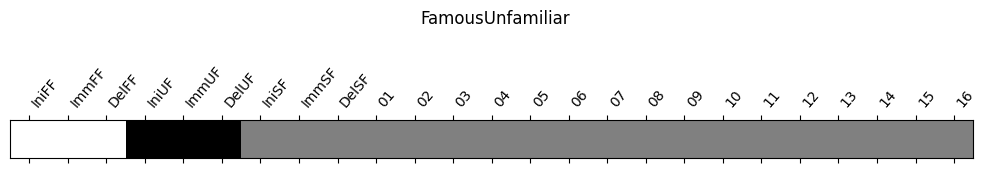

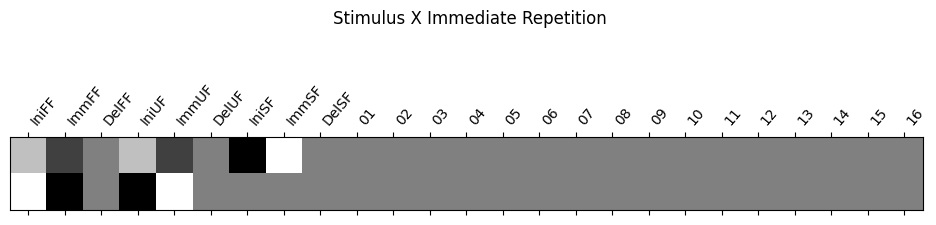

In [12]:
n_columns = design_matrix.shape[1]

contrasts = {
  'FacesScrambled': np.pad([1/6, 1/6, 1/6, 1/6, 1/6, 1/6, -1/3, -1/3, -1/3], (0, n_columns - 9), 'constant'),
  'FamousUnfamiliar': np.pad([1/3, 1/3, 1/3, -1/3, -1/3, -1/3, 0, 0, 0], (0, n_columns - 9), 'constant'),
  'Stimulus X Immediate Repetition': np.array([np.pad(np.kron([1/2, 1/2, -1], [1, -1, 0]), (0, n_columns - 9), 'constant'),
                                               np.pad(np.kron([1,   -1,   0], [1, -1, 0]), (0, n_columns - 9), 'constant')])
}

for contrast_id, contrast_val in contrasts.items():
    plot_contrast_matrix(contrast_val, design_matrix=design_matrix)
    plt.suptitle(contrast_id)

Note that there is no particular scientific reason for the specific F-contrast interaction above, other than to demonstrate how to construct such contrasts.

We could then loop through every contrast like below, using the same threshold:
```python
for contrast_id, contrast_val in contrasts.items():
    print(f"\tcontrast id: {contrast_id}")
    z_map = second_level_model.compute_contrast(contrast_val, output_type="z_score")

    thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = 0.001, 
        height_control = None, 
        two_sided = True)
    
    plot_stat_map(
        thresholded_map, 
        threshold = threshold, 
        bg_img = mni152_template,
        display_mode="ortho",
        black_bg = True,
        cmap = 'hot', 
        title = contrast_id)  
    
    fig = plt.gcf()
    fig.set_size_inches(10,3)
    plt.show()
```
but let's look at each contrast separately. 

##### Faces > Scrambled

Firstly, let's compare the strong Faces > Scrambled contrast using a Bonferonni corrected threshold, to compare with the one-sample T-test above:

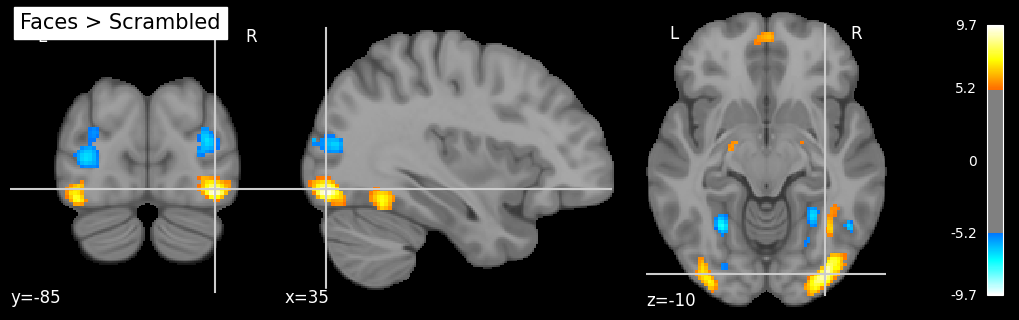

In [13]:
z_map = second_level_model.compute_contrast(contrasts['FacesScrambled'], output_type="z_score")
thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = 0.05, 
        height_control = 'bonferroni', 
        two_sided = True)
plot_stat_map(
        thresholded_map, 
        threshold = threshold, 
        bg_img = mni152_template,
        display_mode="ortho",
        black_bg = True,
        title = 'Faces > Scrambled',
    )       
fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

You can see that there are a lot more voxels than when we used the one-sample T-test. One reason is that we have many more degrees of freedom in this 3x3 ANOVA model, so more power. However, this power comes at the price of assuming that the error is spherical, i.e., that there is equal variance across the 9 conditions, and equal covariance. If this is not true, the statistics are biased, and hence the one-sample T-test approach is safer; see [Rik's Stats notebook](../02_Statistics/cognestic_stats_python.ipynb) for more details. 

##### Famous > Unfamiliar

Next, what about the famous vs unfamiliar contrast. This time we will use a one-tailed FDR correction:

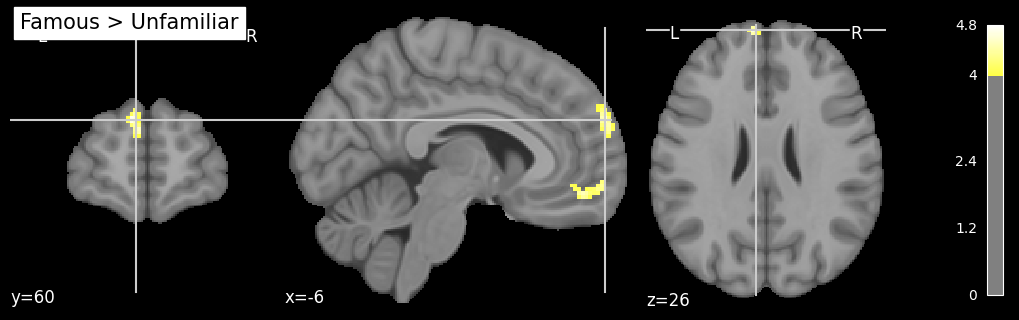

In [14]:
z_map = second_level_model.compute_contrast(contrasts['FamousUnfamiliar'], output_type="z_score")
thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = 0.05, 
        height_control = 'fdr', 
        two_sided = False)
plot_stat_map(
        thresholded_map, 
        threshold = threshold, 
        bg_img = mni152_template,
        display_mode="ortho",
        black_bg = True,
        cmap = 'hot', 
        title = 'Famous > Unfamiliar',
    )       
fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

We can see some medial prefrontal regions that are more active for famous faces (that participants were likely to recognise, and may trigger semantic/emotional responses).

##### Stimulus x Immediate Repetition interaction

Finally, what about the interaction F-contrast we created, which asks whether the effect of repetition depends on whether the repeated stimulus is a face or scrambled face:

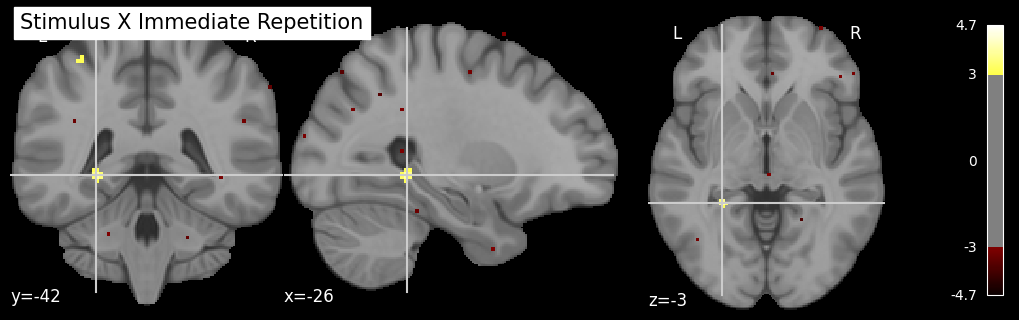

In [24]:
z_map = second_level_model.compute_contrast(contrasts['Stimulus X Immediate Repetition'], output_type="z_score") # Don't need stat_type="F" option?
thresholded_map, threshold = threshold_stats_img(
        z_map, 
        alpha = 0.001, 
        height_control = None,
        two_sided = True)
plot_stat_map(
        thresholded_map, 
        threshold = threshold, 
        bg_img = mni152_template,
        display_mode="ortho",
        black_bg = True,
        cmap = 'hot', 
        title = 'Stimulus X Immediate Repetition',
    )       
fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

There is nothing particularly convincing for this last contrast: unlikely that anything would survive correction for multiple comparisons, but some might be reliable when using more focused Region-of-Interest (ROI) analyses as in the next Notebook... (where we will also be able to plot the 9 conditions in order to understand interactions like this). Note also that the MNI152 template is somewhat misleading in terms of the anatomical precision - progresisvely more accurate would be to overlay the activations on a normalised structural image for one participant, or the average of such structurals across participants, or the average of their normalised mean functional images (which will be blurry and contain distortions, but are closer to the actual resolution in your activations).

Note we can also do interactive plotting:

In [26]:
plt = view_img(
  thresholded_map, 
  bg_img = mni152_template, 
  threshold = threshold, 
  colorbar = True, 
  title = 'Stimulus X Immediate Repetition'
  )
#plt.show()
#plt.open_in_browser() # This might not work on some browsers, in which case save as below and open manually
plt.save_as_html('interactive_results.html')

/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### FWE correction using non-parametric permutation testing

Nilearn's FWE correction using the Bonferroni approach (`height_control='bonferroni'`) is applied to the number of voxels. However, this method is not well-suited for fMRI data because neuroimaging data typically exhibit spatially correlated data points, which violate the Bonferroni assumption of independent tests.

As an alternative, neuroscientists have developed **Random Field Theory** (RFT), which accounts for spatial correlations by applying multiple comparison corrections that consider the smoothness of the data (it can be thought of as a Bonferroni correction based on the number of **'resels'** - RESolution ELements - rather than the raw number of voxels). However, it makes various parametric assumptions about the data, including a minimal smoothness in terms of voxels, that can be violated. More practically, it is not implemented in Nilearn (to our knowledge).

Another alternative, which is implemented in Nilearn, is to use non-parametric inference, specifically permutation testing. This makes fewer assumptions when correcting for multiple comparisons (though note that is assumes exchangeability, which can also be violated if the error is nonspherical under the null; see *[Rik's Stats notebook](../02_Statistics/cognestic_stats_python.ipynb).)* The only downside is that permutation testing can take a long time to run...

In [32]:
out_dict = non_parametric_inference(
    effect_files,
    design_matrix = design_matrix,
    second_level_contrast = contrasts['FacesScrambled'],
    n_perm = 100, # ideally at least 10000
    two_sided_test = False,
    n_jobs = -1, # Use all available cores
    threshold = 0.001 # cluster level threshold; enables cluster-level inference
)

# Print the keys of the output dictionary
print(out_dict.keys())

/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


dict_keys(['t', 'logp_max_t', 'size', 'logp_max_size', 'mass', 'logp_max_mass'])


The output is multiple images (maps), organised in a dictionary. 
* Voxel-level inference
  * **t**: t-statistics
  * **logp_max_t**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum t-statistics from permutations.
* Cluster-level inference
  * **size**: Cluster size values associated with the significance test 
  * **logp_max_size**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster sizes from permutations.
  * **mass**: Cluster mass values associated with the significance test 
  * **logp_max_mass**: Negative log10 family-wise error rate-corrected p-values corrected based on the distribution of maximum cluster masses from permutations. 

**We will focus only on the voxel-level inference.**

To report the FWE-corrected maps, we could display the *logp_max_t*; however, these values can be difficult to interpret if you're not familiar with them. It might be better to plot and report a t-map, masked to exclude the voxels that did not survive the FWE correction.

Let's create a new image displaying t-values for the voxels with a p-value < 0.05.

In [33]:
alpha = 0.05
masked = out_dict['logp_max_t'].get_fdata() > -np.log10(alpha)
masked_t_map = out_dict['t'].get_fdata() * masked

# save the masked t-map as a nifti image
masked_t_map_img = nib.Nifti1Image(masked_t_map, out_dict['t'].affine)

FWE (perm.) p<.05 threshold: 5.085


AttributeError: 'StatMapView' object has no attribute 'gcf'

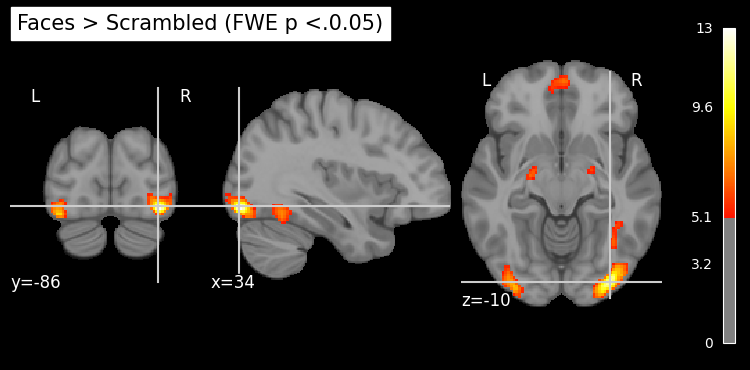

In [34]:
# Get the smallest t-value that is above the threshold (for the colorbar; the maps themselves are thresholded already)
threshold_fwe = masked_t_map[masked_t_map > 0].min()
print('FWE (perm.) p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'ortho',
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In this example, we observe that the non-parametric FWE correction is slightly less conservative than the Bonferroni correction.

## Summary results

### Using atlasreader package

We can use ['atlasreader'](https://github.com/miykael/atlasreader) package to get summary results (peak table, cluster table, .png images of each cluster). 

In [62]:
# generate and save atlasreader output
outdir = op.join(fmri_results_dir, 'group-level', 'permutation', 'FacesScrambled')

create_output(
    masked_t_map_img, 
    cluster_extent = 20, 
    voxel_thresh = threshold_fwe,
    direction = 'pos',
    outdir = outdir
)

In [63]:
# display the peak table
peaks = glob.glob(op.join(outdir, '*_peaks.csv'))
display(pd.read_csv(peaks[0]))

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm  \
0         1.0    35.5   -86.5   -12.5   12.746423     8752.0   
1         2.0   -38.5   -82.5   -16.5    9.130247     2600.0   
2         3.0   -42.5   -56.5   -20.5    9.214361     2184.0   
3         4.0     1.5    57.5   -12.5    6.870070     1680.0   
4         5.0    45.5   -60.5    11.5    6.027462      848.0   
5         6.0   -20.5    -8.5   -14.5    8.559811      736.0   
6         7.0   -52.5   -68.5    17.5    6.445215      584.0   
7         8.0    21.5    -8.5   -14.5    8.055010      544.0   
8         9.0    27.5    -2.5   -20.5    6.675042      312.0   
9        10.0   -32.5    -8.5   -18.5    6.203814      232.0   

                 aal             desikan_killiany  \
0    Occipital_Inf_R  Right-Cerebral-White-Matter   
1         Fusiform_L   Left-Cerebral-White-Matter   
2         Fusiform_L              ctx-lh-fusiform   
3  Frontal_Med_Orb_L                      Unknown   
4     Temporal_Mid_R      ctx-rh-lateraloccipital   
5      Hippocampus_L                Left-Amygdala   
6     Temporal_Mid_L      ctx-lh-lateraloccipital   
7      Hippocampus_R               Right-Amygdala   
8         Amygdala_R               Right-Amygdala   
9      Hippocampus_L   Left-Cerebral-White-Matter   

                                      harvard_oxford  
0  44.0% Right_Lateral_Occipital_Cortex_inferior_...  
1  52.0% Left_Lateral_Occipital_Cortex_inferior_d...  
2  58.0% Left_Temporal_Occipital_Fusiform_Cortex;...  
3  66.0% Right_Frontal_Pole; 16.0% Right_Frontal_...  
4  40.0% Right_Lateral_Occipital_Cortex_inferior_...  
5                                94.0% Left_Amygdala  
6  69.0% Left_Lateral_Occipital_Cortex_superior_d...  
7       90.0% Right_Amygdala; 5.0% Right_Hippocampus  
8                               97.0% Right_Amygdala  
9        14.0% Left_Hippocampus; 13.0% Left_Amygdala

In [64]:
# display the cluster table
clusters = glob.glob(op.join(outdir, '*_clusters.csv'))
display(pd.read_csv(clusters[0]))

cluster_id  peak_x  peak_y  peak_z  cluster_mean  volume_mm  \
0         1.0    35.5   -86.5   -12.5      7.045398     8752.0   
1         2.0   -38.5   -82.5   -16.5      6.321022     2600.0   
2         3.0   -42.5   -56.5   -20.5      6.449768     2184.0   
3         4.0     1.5    57.5   -12.5      5.607778     1680.0   
4         5.0    45.5   -60.5    11.5      5.395861      848.0   
5         6.0   -20.5    -8.5   -14.5      6.180181      736.0   
6         7.0   -52.5   -68.5    17.5      5.532064      584.0   
7         8.0    21.5    -8.5   -14.5      6.039743      544.0   
8         9.0    27.5    -2.5   -20.5      5.643661      312.0   
9        10.0   -32.5    -8.5   -18.5      5.457076      232.0   

                                                 aal  \
0  51.19% Occipital_Inf_R; 30.62% Fusiform_R; 7.6...   
1  46.77% Occipital_Inf_L; 17.23% Fusiform_L; 16....   
2            89.38% Fusiform_L; 5.49% Temporal_Inf_L   
3  47.62% Frontal_Med_Orb_L; 22.86% Frontal_Med_O...   
4                              99.06% Temporal_Mid_R   
5  55.43% Hippocampus_L; 28.26% Amygdala_L; 16.30...   
6                              98.63% Temporal_Mid_L   
7  61.76% Hippocampus_R; 26.47% Amygdala_R; 11.76...   
8  69.23% Amygdala_R; 23.08% Hippocampus_R; 7.69%...   
9  68.97% Hippocampus_L; 24.14% no_label; 6.90% A...   

                                    desikan_killiany  \
0  44.15% Right-Cerebral-White-Matter; 25.41% ctx...   
1  44.31% Left-Cerebral-White-Matter; 44.00% ctx-...   
2  37.36% ctx-lh-fusiform; 36.26% Unknown; 17.22%...   
3  68.10% Unknown; 19.05% ctx-lh-medialorbitofron...   
4  32.08% Right-Cerebral-White-Matter; 22.64% ctx...   
5  50.00% Left-Amygdala; 25.00% Left-Hippocampus;...   
6  35.62% Unknown; 34.25% ctx-lh-lateraloccipital...   
7  63.24% Right-Amygdala; 20.59% Right-Hippocampu...   
8  82.05% Right-Amygdala; 10.26% Right-Cerebral-W...   
9  48.28% Left-Cerebral-White-Matter; 37.93% Left...   

                                      harvard_oxford  
0  36.11% Right_Lateral_Occipital_Cortex_inferior...  
1  64.31% Left_Lateral_Occipital_Cortex_inferior_...  
2  83.52% Left_Temporal_Occipital_Fusiform_Cortex...  
3  39.05% Left_Frontal_Medial_Cortex; 24.76% Righ...  
4  41.51% Right_Lateral_Occipital_Cortex_superior...  
5      82.61% Left_Amygdala; 17.39% Left_Hippocampus  
6  89.04% Left_Lateral_Occipital_Cortex_superior_...  
7    83.82% Right_Amygdala; 16.18% Right_Hippocampus  
8                              97.44% Right_Amygdala  
9      51.72% Left_Amygdala; 48.28% Left_Hippocampus

**Some more plotting options**

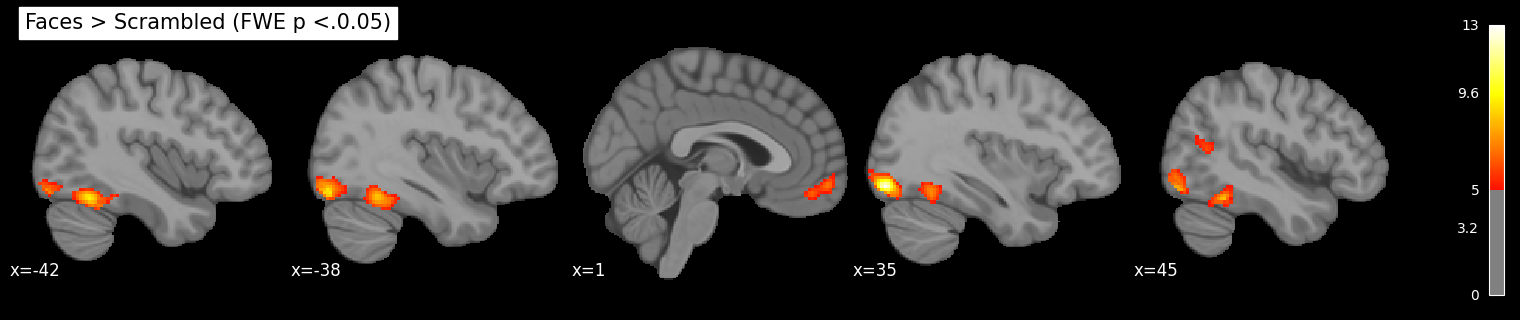

In [65]:
# get the top 5 peaks' x values
x = pd.read_csv(peaks[0])['peak_x'][:5]
# sort the x values
x = x.sort_values()

# plot these peaks
plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'x',
    cut_coords = x,
    black_bg = True,
    bg_img = mni152_template,
    cmap = 'hot',
    title = f"Faces > Scrambled (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(15,3)

We can also look at a 3D brain using `plotly`.

In [66]:
view = view_img_on_surf(masked_t_map_img, threshold = threshold_fwe)
#view.open_in_browser()
view.resize(1600, 800)
view

Or use, for example, FSLeyes to plot and explore the result maps. 

### Nilearn's report

Nilearn has a built-in report generator that can create reports for all defined contrasts. However, a limitation is that it cannot generate reports for results obtained using non-parametric inference.

In [15]:
second_level_report = second_level_model.generate_report(
  contrasts, 
  title = "Results of the second-level analysis", 
  bg_img = mni152_template, 
  alpha = 0.001, 
  cluster_threshold = 20, 
  height_control = 'fpr', 
  min_distance = 8.0, 
  plot_type = 'slice', 
  display_mode = 'x', 
  report_dims = (1600, 800))

#second_level_report.open_in_browser()

In [16]:
second_level_report.save_as_html('/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/results/group-level/nilearn_report.html')